In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import zip_longest
import mpl_toolkits.axisartist.axislines as axislines
from scipy.stats.stats import pearsonr   
from scipy.stats import entropy
from scipy.stats import iqr
#from talib import abstract
import scipy.stats as stats
from scipy.stats import kurtosis, skew
import turtle
import scipy.signal
from scipy.fftpack import fft,ifft
#from sklearn.model_selection import train_test_split
import math
import copy
data_by_type = ['by_human','by_trolley']
coord = ['x','y','z']
sensor_type = 1
test_path = 'test_0823'
xticks_array = []
yticks_array = []
support_sensors = [1, 10, 4, 9, 2, 11, 3]
current_sensor = ''
'''
Sensor	Type	Description	Common Uses
1.TYPE_ACCELEROMETER	Hardware	Measures the acceleration force in m/s2 that is applied to a device on all three physical axes (x, y, and z), including the force of gravity.	Motion detection (shake, tilt, etc.).
2.TYPE_AMBIENT_TEMPERATURE	Hardware	Measures the ambient room temperature in degrees Celsius (°C). See note below.	Monitoring air temperatures.
3.TYPE_GRAVITY	Software or Hardware	Measures the force of gravity in m/s2 that is applied to a device on all three physical axes (x, y, z).	Motion detection (shake, tilt, etc.).
4.TYPE_GYROSCOPE	Hardware	Measures a device's rate of rotation in rad/s around each of the three physical axes (x, y, and z).	Rotation detection (spin, turn, etc.).
5.TYPE_LIGHT	Hardware	Measures the ambient light level (illumination) in lx.	Controlling screen brightness.
6.TYPE_LINEAR_ACCELERATION	Software or Hardware	Measures the acceleration force in m/s2 that is applied to a device on all three physical axes (x, y, and z), excluding the force of gravity.	Monitoring acceleration along a single axis.
7.TYPE_MAGNETIC_FIELD	Hardware	Measures the ambient geomagnetic field for all three physical axes (x, y, z) in μT.	Creating a compass.
8.TYPE_ORIENTATION	Software	Measures degrees of rotation that a device makes around all three physical axes (x, y, z). As of API level 3 you can obtain the inclination matrix and rotation matrix for a device by using the gravity sensor and the geomagnetic field sensor in conjunction with the getRotationMatrix() method.	Determining device position.
9.TYPE_PRESSURE	Hardware	Measures the ambient air pressure in hPa or mbar.	Monitoring air pressure changes.
10.TYPE_PROXIMITY	Hardware	Measures the proximity of an object in cm relative to the view screen of a device. This sensor is typically used to determine whether a handset is being held up to a person's ear.	Phone position during a call.
11.TYPE_RELATIVE_HUMIDITY	Hardware	Measures the relative ambient humidity in percent (%).	Monitoring dewpoint, absolute, and relative humidity.
12.TYPE_ROTATION_VECTOR	Software or Hardware	Measures the orientation of a device by providing the three elements of the device's rotation vector.	Motion detection and rotation detection.
13.TYPE_TEMPERATURE	Hardware	Measures the temperature of the device in degrees Celsius (°C). This sensor implementation varies across devices and this sensor was replaced with the TYPE_AMBIENT_TEMPERATURE sensor in API Level 14	Monitoring temperatures.
Attainable Sensor:1,2,3,4,9,10,11

Feature categorization:
- Time Domain
    - Mean
    - Variance
    - Peak
    - Peak interval
    - Skewness
    - Kurtosis
    - Energy
    - Entropy
    - Correlation coefficients
    - RMS
    - Zero/mean crossing rate
- Frequency Domain
    - FFT bins
    - wavelet coefficients
    - MFCCs
    - BFCCs
    - Peak frequency
    - Spectral entropy
    - Power ratio of different frequency bands
- Other Domain
    - PCA
    - Autoencoder networks
    - Sparse coding
    - Weightlessness feature
'''
features = []
def calibrate_median(data):
    medianvalue = np.median(data)
    return np.array([x - medianvalue for x in data])


def calibrate_minimum(data):
    minimumvalue = np.min(data)
    return np.array([x - minimumvalue for x in data])


def medfilt(x, k):
    # Apply a length-k median filter to a 1D array x.
    # Boundaries are extended by repeating endpoints.

    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros((len(x), k), dtype=x.dtype)
    y[:, k2] = x
    for i in range(k2):
        j = k2 - i
        y[j:, i] = x[:-j]
        y[:j, i] = x[0]
        y[:-j, -(i + 1)] = x[j:]
        y[-j:, -(i + 1)] = x[-1]
    return np.median(y, axis=1)
def butterFilt(array):
    '''
    fc = 20 #cutoff frequency of filter
    fs = 10 # sampling frequency
    normalized_cutoff_freq = 2 * fc / fs
    numerator_coeffs, denominator_coeffs = scipy.signal.butter(3, normalized_cutoff_freq,fs=fs,output='ba')
    filtered_signal = scipy.signal.lfilter(numerator_coeffs, denominator_coeffs, array)
    return filtered_signal
    '''
    return array
def calc_sma_for_window(data):
    return np.sum(data) / len(data)


def calc_sma_adv_for_window(data):
    return np.sum(data - np.mean(data) / len(data))


def calc_absolutes_for_list(list):
    return ([abs(i) for i in list])


def calc_sma(x,y,z):
    '''
    sma_sim = calc_sma_for_window(data)
    sma_adv = calc_sma_adv_for_window(data)

    sma_sim_abs = calc_sma_for_window(calc_absolutes_for_list(data))
    sma_adv_abs = calc_sma_adv_for_window(calc_absolutes_for_list(data))

    return {'sma_sim':sma_sim, 'sma_adv':sma_adv, 'sma_sim_abs':sma_sim_abs, 'sma_adv_abs' :sma_adv_abs}
    '''
    total = 0;
    for i in range(len(x)):
        total += abs(x[i]) + abs(y[i]) + abs(z[i]);
    return total /len(x);
    
def apply_filter(df):
    global features, current_sensor, file_name
    def reset_feature_str(time_or_freq):
        feature_str = ''
        if time_or_freq == 0 or time_or_freq == 1:
            feature_str += 't'
        elif time_or_freq == 2 or time_or_freq == 3:
            feature_str += 'f'
        feature_str += current_sensor
        if time_or_freq == 3 or time_or_freq == 1:
            feature_str += 'Mag'
        return feature_str
    i = 1
    time = df['timestamp']
    values = df['values']

    last_time = time.iloc[0] 
    last_index = 0
    
    new_df = pd.DataFrame()
    output_x = pd.DataFrame()
    output_y = pd.DataFrame()
    output_z = pd.DataFrame()
    #new_dict = {'timestamp': last_time, 'x': values.iloc[0],''}
    #new_df = new_df.append(new_dict,ignore_index = True)
    while i < len(time) - 1:
        if time.iloc[i] - last_time <= 2000:
            #new_df['values'].iloc[last_index].append(df['values'].iloc[i])
            pass
        elif time.iloc[i] - last_time > 2000:
            valuess = pd.Series(np.array((df.loc[np.logical_and(df['timestamp'] - last_time <= 2000,df['timestamp'] - last_time >=0)]['values'].apply(pd.Series).stack())))
            #print("x:")
            #print(valuess[valuess.index %3 == 0])
            mag = np.array([])
            x = []
            y = []
            z = []
            new_dict = dict()
            for time_or_freq in range(4):
                if time_or_freq == 0:
                    #output_x = output_x.append(np.array(valuess[valuess.index %3 == 0]), ignore_index = True)
                    #output_y = output_y.append(np.array(valuess[valuess.index %3 == 1]), ignore_index = True)
                    #output_z = output_z.append(np.array(valuess[valuess.index %3 == 2]), ignore_index = True)
                    x = np.array(medfilt(butterFilt(np.array(valuess[valuess.index %3 == 0])),3))
                    y = np.array(medfilt(butterFilt(np.array(valuess[valuess.index %3 == 1])),3))
                    z = np.array(medfilt(butterFilt(np.array(valuess[valuess.index %3 == 2])),3))
                    for k in range(len(x)):
                        mag = np.append(mag, np.sqrt(x[k]*x[k] + y[k]*y[k]+z[k]*z[k]))
                elif time_or_freq == 2:
                    mag = np.array([])
                    x = []
                    y = []
                    z = []
                    x = np.abs(fft(medfilt(butterFilt(np.array(valuess[valuess.index %3 == 0])),3)))/len(valuess[valuess.index %3 == 0])
                    y = np.abs(fft(medfilt(butterFilt(np.array(valuess[valuess.index %3 == 1])),3)))/len(valuess[valuess.index %3 == 1])
                    z = np.abs(fft(medfilt(butterFilt(np.array(valuess[valuess.index %3 == 2])),3)))/len(valuess[valuess.index %3 == 2])
                    for k in range(len(x)):
                        mag = np.append(mag,np.sqrt(x[k]*x[k] + y[k]*y[k]+z[k]*z[k]))
                xyzMag = {'X':x,'Y':y,'Z':z,'Mag':mag}
                
                for coord in xyzMag.keys():
                    append_coord = ''
                    if (coord != 'Mag' and time_or_freq % 2 == 0) or (coord == 'Mag' and time_or_freq % 2 == 1):
                        feature_str = reset_feature_str(time_or_freq)
                        if (coord != 'Mag' and time_or_freq % 2 == 0):
                            append_coord = coord
                        new_dict['last_time'] = last_time 
                        new_dict['time.iloc[i]'] = time.iloc[i]
                        new_dict['i'] = i
                        new_dict[feature_str + 'min' + append_coord] = min(xyzMag[coord])
                        new_dict[feature_str + 'max' + append_coord] = max(xyzMag[coord])
                        new_dict[feature_str + 'mean' + append_coord] = xyzMag[coord].mean()
                        new_dict[feature_str + 'std' + append_coord] = xyzMag[coord].std(ddof = 1)
                        new_dict[feature_str + 'skewness' + append_coord] = skew(xyzMag[coord])
                        new_dict[feature_str + 'kurtosis' + append_coord] = kurtosis(xyzMag[coord])
                        new_dict[feature_str + 'mad' + append_coord] = pd.Series(xyzMag[coord]).mad()
                        new_dict[feature_str + 'energy' + append_coord] = sum(xyzMag[coord]**2)/len(xyzMag[coord])
                        new_dict[feature_str + 'iqr' + append_coord] = iqr(xyzMag[coord])
                        new_dict[feature_str + 'entropy' + append_coord] = entropy(xyzMag[coord])
                if (time_or_freq%2 == 0):
                    new_dict[feature_str + 'correlationXY'] = np.corrcoef(xyzMag['X'],xyzMag['Y'])[0][1]
                    new_dict[feature_str + 'correlationXZ'] = np.corrcoef(xyzMag['X'],xyzMag['Z'])[0][1]
                    new_dict[feature_str + 'correlationYZ'] = np.corrcoef(xyzMag['Y'],xyzMag['Z'])[0][1]
            new_dict[feature_str + 'sma'] = calc_sma(xyzMag['X'],xyzMag['Y'],xyzMag['Z'])
                
                #new_new_dict = {'x':x,'y':y,'z':z}
                #features = new_dict.keys
            new_df = new_df.append(new_dict,ignore_index = True)
            last_time = time.iloc[i]
        i += 1
       
    new_df.to_csv("./CSV/" + file_name + '_' + current_sensor +'.csv')
    return new_df
def divide_type_main():
    global current_sensor
    current_sensor_dict = {1:'BodyAcc',3:'GravityAcc',4:'BodyGyro'}
    
    data_group = dict()
    for situation in range(10):
        sensor_dict = dict()
        for sensor in current_sensor_dict.keys():
            current_sensor = current_sensor_dict[sensor]
            sensor_dict.setdefault(str(sensor),apply_filter(divide_type(read_file(which_type = situation))[sensor]))
        data_group.setdefault(str(situation), sensor_dict)
            
    print(data_group)        
    '''
    plt.figure(figsize=(8,12))
    
    for situation in data_group:
            for features in data_group[data_member]['0'].columns:
                if features.find('timestamp') == -1:
                    fig, axes = plt.subplots()
                    y_human_a = np.array(data_group[data_member]['0'][features].apply(pd.Series).stack())
                    x = range(len(y_human_a))
                    axes.plot(x,y_human_a,'g',label='by human (handhold)')
                    y_human_b = np.array(data_group[data_member]['3'][features].apply(pd.Series).stack())
                    x = range(len(y_human_b))
                    axes.plot(x,y_human_b,'m',label='by human (waist)')
                    y_trolley_a = np.array(data_group[data_member]['1'][features].apply(pd.Series).stack())
                    x = range(len(y_trolley_a))
                    axes.plot(x,y_trolley_a,'b',label='by trolley(inclined)')
                    y_trolley_b = np.array(data_group[data_member]['2'][features].apply(pd.Series).stack())
                    x = range(len(y_trolley_b))
                    axes.plot(x,y_trolley_b,'r',label='by trolley(standing)')

                    axes.set_xlabel('Time/2s',fontsize=12)
                    axes.set_ylabel('Value',fontsize=12)
                    title = "Feature- " + features + " obtained in sensor- " + data_member
                    axes.set_title(title)
                    plt.legend(loc='upper left')
                    
                    test_path = 'test_0823'
                    png_name = title.replace(" ","_") + ".png"
                    path = './Graph/'+test_path+'/' + png_name
                    fig1 = plt.gcf()
                    #plt.show()
                    #plt.draw()
                    #fig1.savefig(path)
    
    z_old = None #storing old gravity
    z_new = 0 #storing new gravity
    last_peak_time = 0
    this_peak_time = ac_data_human['timestamp'].iloc[0]
    start_time = ac_data_human['timestamp'].iloc[0]
    peak_of_wave = 0
    valley_of_wave = 0
    is_direction_up = False
    continue_up_count = 0
    prev_continue_up_count = 0
    time_threshold = 10000
    z_mean = 9.06675
    z_sd = 1.63407
    z_threshold =  z_sd
    human_threshold = 1 * z_sd
    step_count = 0
    orig_value = []
    peak_diff_list = []
    last_detected = None
    data_len = len(ac_data_human.index)
    file_name = ''
    def detect_peak(z_old,z_new): #input z_old and z_new, detect whether a peak or valley has occurred in these two timeframe
        nonlocal last_detected,last_peak_time, this_peak_time, peak_of_wave, valley_of_wave, is_direction_up,prev_continue_up_count, continue_up_count, time_threshold, z_threshold, ac_data_human, ac_data_trolley, orig_value, data_len 
        last_status = is_direction_up
        if z_new >= z_old:
            is_direction_up = True
            continue_up_count += 1
        else:
            prev_continue_up_count = continue_up_count
            is_direction_up = False
            continue_up_count = 0
        if not is_direction_up and last_status: #two z value changed direction and increased 2 time, with the old value larger than z_mean + 1 * sd
            peak_of_wave = z_old
            return 'peak'
        elif is_direction_up and not last_status: # last status is downward and now is upward, where valley occurred
            valley_of_wave = z_old
            return 'valley'
        else:
            return 'other'
            
    
    def classify(orig_value = ac_data_human['values']):#input
        nonlocal human_threshold, last_detected,peak_diff_list, step_count, z_old,z_new, last_peak_time, start_time, this_peak_time, peak_of_wave, valley_of_wave, is_direction_up, continue_up_count, time_threshold, z_threshold, ac_data_human, ac_data_trolley, data_len 
        
        for i in range(0,data_len-1):
            xyz_value = orig_value[i]
            
            if not z_old:
                z_old = xyz_value[2]
            else:
                z_new = xyz_value[2]
                detect_peak_value = detect_peak(z_old,z_new)
                if (detect_peak_value == 'peak' and (not last_detected or last_detected == 'valley')): #if a peak is detected, meaning it has fulfilled requirement on threshold and time difference
                    peak_diff_list.append(peak_of_wave - valley_of_wave)
                    last_detected = 'peak'
                elif (detect_peak_value == 'valley' and (not last_detected or last_detected == 'peak')):
                    peak_diff_list.append(abs(valley_of_wave - peak_of_wave))
                    last_detected = 'valley'
                z_old = z_new
        peak_avg = sum(peak_diff_list) / len(peak_diff_list)
        #print(peak_avg)
        if peak_avg >= human_threshold:
            return 'human'
        else:
            return 'trolley'
                
    #2
    return classify()
    '''
    #print(body_ac_data_trolley)
def plot_normal_graph(data_list, which_type):
    global data_by_type ,coord ,sensor_type,test_path
    for which_coord in range(3):
        data_by = data_by_type[which_type]
        title = "Normal Distribution graph of " + coord[which_coord] + "-coordinate [#"+ str(sensor_type) + "] collected " + data_by.replace("_"," ")
        temp_data = data_list[sensor_type]['values']
        temp_data = pd.DataFrame.from_records(zip_longest(*temp_data.values)).T[which_coord]
        sorted_data = sorted(temp_data)
        fitting = stats.norm.pdf(sorted_data, np.mean(sorted_data), np.std(sorted_data))
        plt.figure(figsize=(12,6))
        plt.plot(sorted_data, fitting)
        mean = np.mean(sorted_data)
        std = np.std(sorted_data)
        kurt = kurtosis(sorted_data)
        skewness = skew(sorted_data)
        plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
        plt.hist(sorted_data,80,  density=True, color='lightblue')
        plt.xlabel(coord[which_coord].upper() + "-coordinate",fontsize = 15)
        plt.ylabel('Frequency',fontsize = 15)
        plt.title(title, fontsize=20)
        plt.figtext(.67, .65, "mean = " + str("{:.5f}".format(mean)) + "\nstandard deviation = " + str("{:.5f}".format(std))
                + "\nmax = " + str("{:.5f}".format(max(sorted_data))) + "\nmin = " + str("{:.5f}".format(min(sorted_data)))
                + "\nkurtosis = " + str("{:.5f}".format(kurt)) + "\nskew = " + str("{:.5f}".format(skewness)),fontsize = 13)
        png_name = title.replace(" ","_") + ".png"
        path = './Graph/'+test_path+'/' + png_name
        plt.show()
        plt.savefig(path)
def plot_time_graph(data_list_a, data_list_b,which_type):
    global data_by_type,coord,sensor_type, xticks_array, yticks_array, file_name, test_path
    #plot timestamp vs x, timestamp vs y, timestamp vs z graph
    #draw graph according to: mean, sd, kurtosis, skewness
    #draw graph according to: 
    for which_coord in range(3):
        data_by = data_by_type[which_type]
        title = "Data collected in " + coord[which_coord] + "-coordinates [#" + str(sensor_type) + " sensor] of " + file_name + " vs time"
        y_label = "Time (milliseconds)"
        x_label = coord[which_coord] + "-coordinates"
        y_data_a = data_list_a[sensor_type]['values']
        y_data_a = pd.DataFrame.from_records(zip_longest(*y_data_a.values)).T[which_coord]
        #print("y_data_a")
        #print(y_data_a)
        x_data_a = data_list_a[sensor_type]['timestamp']
        x_data_a = x_data_a - x_data_a[0]
        #print("x_data_a")
        #print(x_data_a)
        y_data_b = data_list_b[sensor_type]['values']
        #y_data_b = y_data_b[:len(y_data_a)]
        y_data_b = pd.DataFrame.from_records(zip_longest(*y_data_b.values)).T[which_coord]
        #print("y_data_b")
        #print(y_data_b)
        x_data_b = data_list_b[sensor_type]['timestamp']
        #x_data_b = x_data_b[:len(x_data_a)]
        x_data_b = x_data_b - x_data_b[0]
        #print("x_data_b")
        #print(x_data_b)
        fig, axes = plt.subplots()
        axes.plot(x_data_a,y_data_a,'g',label='by_human')
        axes.plot( x_data_b,y_data_b,'b',label = 'by_trolley')
        plt.legend(loc='upper left')
        axes.set_xlabel(y_label,fontsize=12)
        axes.set_ylabel(x_label,fontsize=12)
        axes.set_title(title, fontsize=15)
        x_data = pd.Series(dtype = float)
        x_data = x_data.append(x_data_a)
        x_data = x_data.append(x_data_b)
        y_data = pd.Series(dtype = float)
        y_data = y_data.append(y_data_a)
        y_data = y_data.append(y_data_b)
        #print("x_data")
        #print(x_data)
        #print("y_data")
        #print(y_data)
        mid_x_data = (min(x_data)+max(x_data))/2
        xticks_array = [min(x_data), ( min(x_data) + mid_x_data )/2 , mid_x_data,(mid_x_data + max(x_data))/2 , max(x_data)]
        axes.set_xticks(xticks_array)
        mid_y_data = (min(y_data)+max(y_data))/2
        yticks_array = [min(y_data), ( min(y_data) + mid_y_data )/2 , mid_y_data,(mid_y_data + max(y_data))/2 , max(y_data)]
        axes.set_yticks(yticks_array)
        png_name =  title.replace(" ","_") + ".png"
        path = './Graph/'+test_path+'/' + png_name
        fig1 = plt.gcf()
        plt.show()
        plt.draw()
        fig1.savefig(path, dpi=100)
def divide_type(data_list):
    result_dict = {}
    for data in data_list:
        if data['type'] in result_dict:
            result_dict[data['type']].append(data)
        else:
            result_dict[data['type']] = [data]
    for sensor_type in result_dict:
        result_dict[sensor_type] = pd.DataFrame(data = result_dict[sensor_type])
    return result_dict
def read_file(which_type):
    global file_name
    #if which_type == 0:
    #    file_name = 'by_human_pocket_train'
    
    if which_type == 0:
        file_name = 'by_human_handhold_train'
        
    elif which_type == 1:
        file_name = 'by_trolley_inclined_train'
    elif which_type == 2:
        file_name = 'by_trolley_standing_train'
    elif which_type == 3:
        file_name = 'by_human_waist_train'
    elif which_type == 4:
        file_name = 'by_human_pocket_train'
    elif which_type == 5:
        file_name = 'by_human_upstairs_train_1'
    elif which_type == 6:
        file_name = 'by_human_downstairs_train_1'
    elif which_type == 9:
        file_name = 'by_human_running_train'
    elif which_type == 7:
        file_name = 'by_human_upstairs_train_2'
    elif which_type == 8:
        file_name = 'by_human_downstairs_train_2'
    else:
        file_name = data_by_type[which_type]
    
    f = open("./Data/" + file_name + "_0823" + ".txt","r")
    #print("f.read()")
    #print(f.read())
    #print("f.read().split(\"}\")")
    raw_data_list = f.read().split("}")
    data_dict_list = list()
    for item in raw_data_list:
        if item != '':
            item += "}"
            data_dict_list.append(json.loads(item))
    return data_dict_list
def plot_graph_main():
    #for which_type in range(2):
    data_list_by_human = read_file(which_type = 0)
    data_list_by_trolley = read_file(which_type = 1)
    data_list_by_human = divide_type(data_list = data_list_by_human)
    data_list_by_trolley = divide_type(data_list = data_list_by_trolley)
    plot_time_graph(data_list_a = data_list_by_human ,data_list_b = data_list_by_trolley, which_type = 0)
    plot_normal_graph(data_list = data_list_by_human, which_type = 0)
    plot_normal_graph(data_list = data_list_by_trolley, which_type = 1)
pd.set_option('display.float_format',lambda x : '%.6f' % x)
divide_type_main()

In [5]:
divide_type_main()

KeyboardInterrupt: 

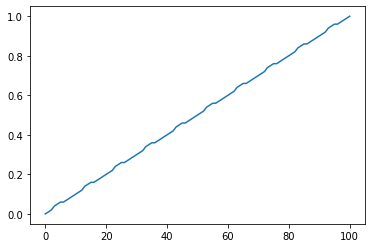

In [79]:
import numpy as np


def calibrate_median(data):
    medianvalue = np.median(data)
    return np.array([x - medianvalue for x in data])


def calibrate_minimum(data):
    minimumvalue = np.min(data)
    return np.array([x - minimumvalue for x in data])


def medfilt(x, k):
    # Apply a length-k median filter to a 1D array x.
    # Boundaries are extended by repeating endpoints.

    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros((len(x), k), dtype=x.dtype)
    y[:, k2] = x
    for i in range(k2):
        j = k2 - i
        y[j:, i] = x[:-j]
        y[:j, i] = x[0]
        y[:-j, -(i + 1)] = x[j:]
        y[-j:, -(i + 1)] = x[-1]
    return np.median(y, axis=1)


def test():
    import pylab as p
    x = np.linspace(0, 1, 101)
    x[3::10] = 1.5
    #p.plot(x)
    #p.plot(medfilt(x, 3))
    p.plot(medfilt(x, 5))
    p.show()


if __name__ == '__main__':
    test()